# Import Data and Data Processing

In [1]:
#Import initial packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
sns.set_context('notebook') 
sns.set_style('ticks')
red='#F68B8B'
blue='#1F77B4'
%matplotlib inline

In [2]:
# Predefined plots

# Time series plot
def ts_plot(y, color=red):
    fig, ax= plt.subplots(figsize=(15,6))
    y.plot(color=color, ax=ax)
    ax.set_xlabel('')
    ax.set_xticks([], minor=True)
    sns.despine()
    return fig, ax

# ACF and PACF plots
def acf_pacf_plot(y):
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    sm.graphics.tsa.plot_acf(y, lags=40, ax=ax[0])
    sm.graphics.tsa.plot_pacf(y, lags=40, ax=ax[1])
    sns.despine()
    fig.tight_layout()
    return fig, ax

#Histogram
def hist(y):
    fig, ax= plt.subplots(figsize=(8,5))
    sns.distplot(y, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': blue},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    return fig, ax

In [3]:
#Read in data
data = pd.read_csv('Rossman Sales.csv', index_col='Date', parse_dates = True, dayfirst = True)
data.index=data.index.to_period(freq='D')
data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [4]:
#Delete unused columns
del data['Customers']
del data['Promo']
del data['StateHoliday']
del data['SchoolHoliday']

In [5]:
#Identify stores open all 7 days every day
stores = list(data['Store'].unique())
all_7_days = []
for i in stores:
    if len(data.loc[(data['Store']==i) & (data['Open']==1)]) == 942:
        all_7_days.append(i)

all_7_days

[85, 262, 335, 423, 494, 562, 682, 733, 769, 1097]

In [6]:
#Create data frame of just these stores
open_seven_stores = [85, 262, 335, 423, 494, 562, 682, 733, 769, 1097]
data_open_seven = pd.DataFrame()
for store in open_seven_stores:
    data_open_seven = data_open_seven.append(data[data['Store'] == store], ignore_index = False)

In [7]:
#Delete unused variables and scale down sales by 1000
del data_open_seven['Open']
del data_open_seven['Store']
data_open_seven['Sales'] = data_open_seven['Sales']/1000
data_open_seven.head()

,DayOfWeek,Sales
Date,,
2015-07-31,5,7.791
2015-07-30,4,7.187
2015-07-29,3,7.719
2015-07-28,2,7.533
2015-07-27,1,7.788


In [8]:
#Sum sales for each day
y = data_open_seven.groupby('Date')['Sales'].sum()
y.head()

Date
2013-01-01     70.278
2013-01-02    102.884
2013-01-03     99.523
2013-01-04    101.280
2013-01-05     83.551
Freq: D, Name: Sales, dtype: float64

# EDA

In [9]:
y.describe()

count    942.000000
mean     124.463365
std       19.560809
min       70.278000
25%      109.323000
50%      124.920000
75%      137.102000
max      189.543000
Name: Sales, dtype: float64

In [10]:
#Identify largest values
y.sort_values().tail()

Date
2015-04-30    179.630
2015-04-02    182.124
2014-12-15    182.975
2014-12-05    185.525
2013-12-16    189.543
Freq: D, Name: Sales, dtype: float64

In [11]:
#Calculate variances for stability purposes
print('Variance of Sales in first half of data', (y[:471].std())**2)
print('Variance of Sales in second half of data', (y[471:].std())**2)

Variance of Sales in first half of data 352.16767033603423
Variance of Sales in second half of data 394.03984853997383


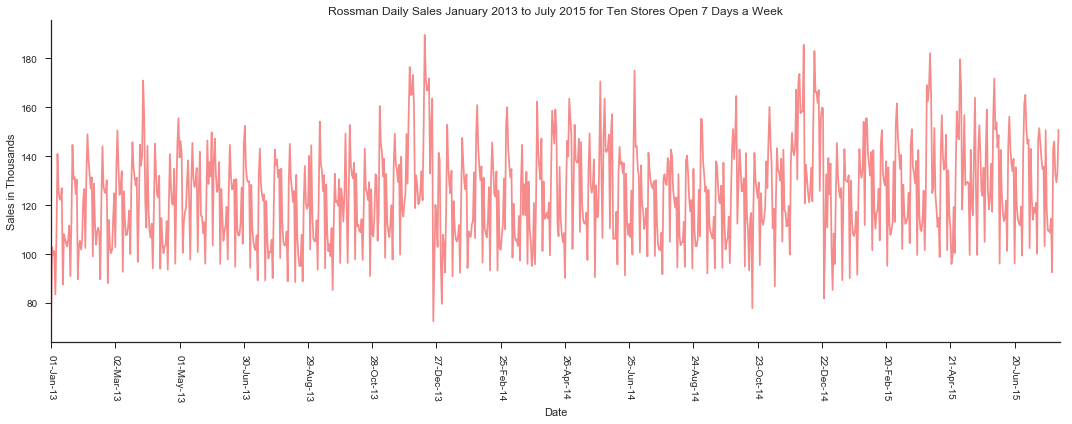

In [12]:
#Time series plot over data
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(y.values, color=red)

ax.set_xlim(0, len(y))

indexes = np.arange(0, len(y), 60) # we will place ticks every 30 days, starting with the first observation 
ax.set_xticks(indexes)
ax.set_xticklabels([y.index[i].strftime('%d-%b-%y') for i in indexes], rotation='-90')

ax.set_xlabel('Date')
ax.set_ylabel('Sales in Thousands')
ax.set_title('Rossman Daily Sales January 2013 to July 2015 for Ten Stores Open 7 Days a Week')

plt.tight_layout()

sns.despine()
plt.show()
fig.savefig('timeseries.png', bbox_inches='tight')

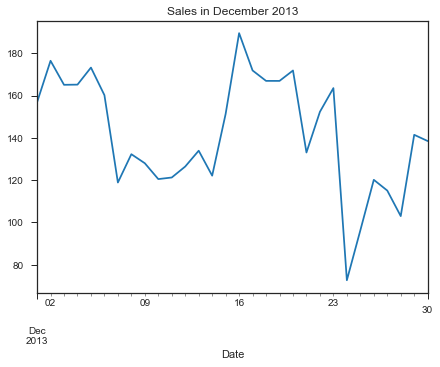

In [13]:
#Check sales on Christmas as it related to rest of December
fig, ax = plt.subplots(figsize=(7,5))
y['2013-12-01':'2013-12-30'].plot(ax=ax)
ax.set_title('Sales in December 2013')
fig.savefig('2013dec.png',bbox_inches='tight')

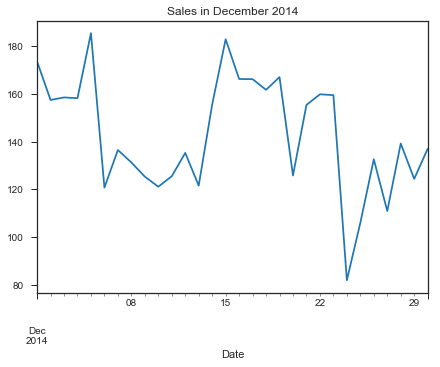

In [14]:
#Same as above cell but for 2014
fig, ax = plt.subplots(figsize=(7,5))
y['2014-12-01':'2014-12-30'].plot(ax=ax)
ax.set_title('Sales in December 2014')
fig.savefig('2014dec.png',bbox_inches='tight')

In [15]:
#Replace Christmas and Christmas Eve to adjust for extreme residuals
y['2013-12-25']=y['2013-12-18']
y['2014-12-25']=y['2013-12-18']
y['2013-12-24']=y['2013-12-17']
y['2014-12-24']=y['2014-12-17']

In [16]:
#Unit-root test to see for stationary
from pandas import Series
from statsmodels.tsa.stattools import adfuller
stats = adfuller(y)
print('Augmented Dickey-Fuller Stat', stats[0])
print('p-value', stats[1])

Augmented Dickey-Fuller Stat -5.11208586743
p-value 1.32553733783e-05


In [17]:
#Redefine Days variable from number to string with actual name
days_dict = {1:'Mon',
             2:'Tue',
             3:'Wed',
             4:'Thu',
             5:'Fri',
             6:'Sat',
             7:'Sun'}
data_open_seven['DayOfWeek'] = data_open_seven['DayOfWeek'].map(days_dict).astype(str)
data_open_seven.head()

,DayOfWeek,Sales
Date,,
2015-07-31,Fri,7.791
2015-07-30,Thu,7.187
2015-07-29,Wed,7.719
2015-07-28,Tue,7.533
2015-07-27,Mon,7.788


In [18]:
#Calculate sum and mean sals by day
days = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
sum_by_day = []
for day in days:
    sum_sales = data_open_seven.loc[data_open_seven['DayOfWeek'] == day].sum()['Sales']
    sum_by_day.append(sum_sales)

sum_days = pd.DataFrame(sum_by_day,days,columns=['Sum Sales'])

mean_by_day = []
for day in days:
    mean_sales_p1 = data_open_seven.loc[data_open_seven['DayOfWeek'] == day].sum()['Sales']
    mean_sales = mean_sales_p1/((len(data_open_seven[data_open_seven['DayOfWeek']==day]))/len(open_seven_stores))
    mean_by_day.append(mean_sales)

mean_days = pd.DataFrame(mean_by_day,days,columns = ['Mean Sales'])

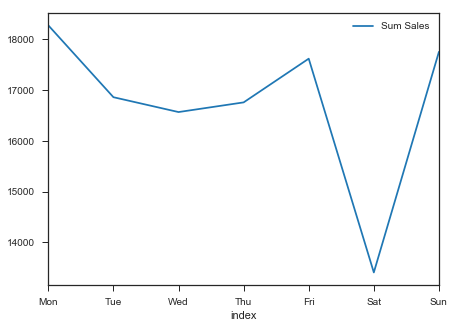

In [19]:
#Plot sum sales by day
fig, ax = plt.subplots(figsize=(7,5))
sum_days.reset_index().plot(x='index', y=0, ax=ax)
fig.savefig('sumsales.png',bbox_inches='tight')

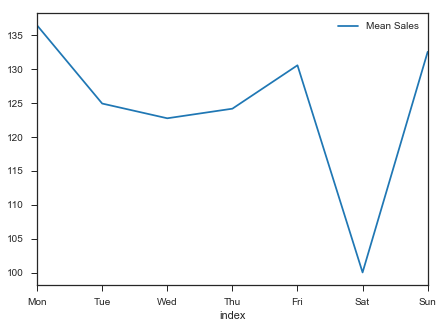

In [20]:
#Plot mean sales by day
fig, ax = plt.subplots(figsize=(7,5))
mean_days.reset_index().plot(x='index', y=0, ax=ax)
fig.savefig('meansales.png',bbox_inches='tight')

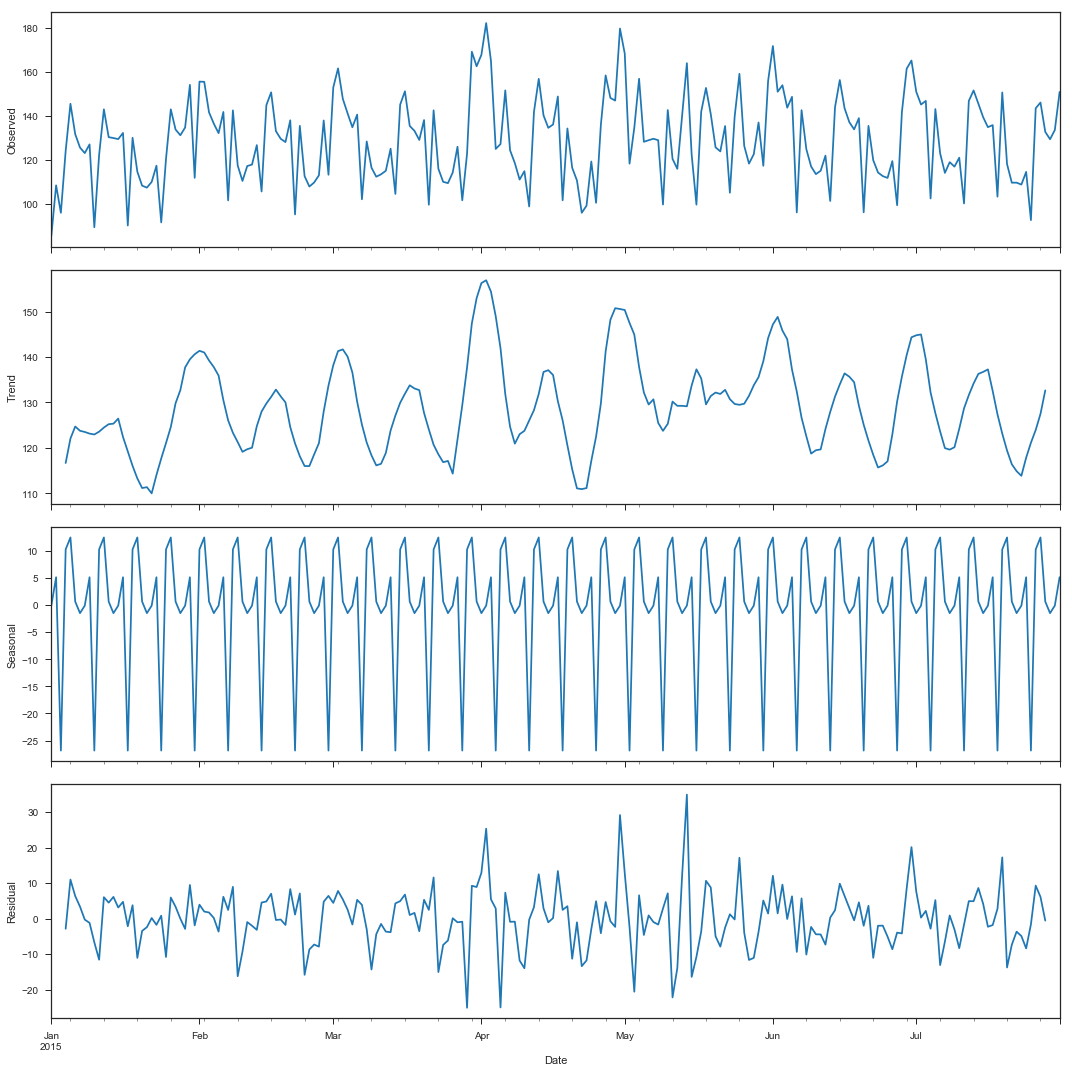

In [21]:
#Plot decomposition of time series
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

y.index = y.index.to_timestamp()

decomposition = sm.tsa.seasonal_decompose(y[730:], model='additive')
fig = decomposition.plot()
plt.show()
fig.savefig('decomp.png',bbox_inches='tight')

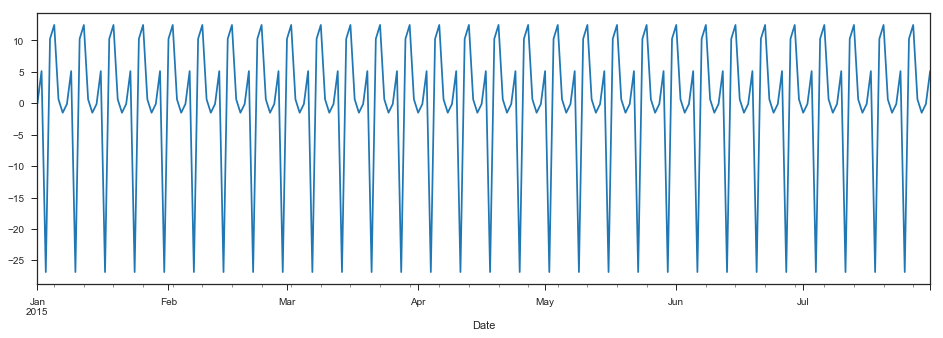

In [22]:
#Decomposition of just seasonal component
fig, ax = plt.subplots(figsize=(16,5))
decomposition.seasonal.plot(ax=ax)
fig.savefig('seasonality.png', bbox_inches='tight')

## Modeling

## Benchmark - Seasonal Random Walk

In [23]:
#Set forecasts equal to last observed value
y.index=y.index.to_period(freq='D')
h = 42
test=pd.period_range(start=y.index[-1]+1, periods=h,freq='D')
pred=pd.Series(np.repeat(y.iloc[-1], h), index=test) # the forecast repeats the last observed values h times
pred.head()

2015-08-01    150.821
2015-08-02    150.821
2015-08-03    150.821
2015-08-04    150.821
2015-08-05    150.821
Freq: D, dtype: float64

In [24]:
#The shift lags the series by one seasonal period
resid_rw=y-y.shift(7)
sigma = resid_rw.std()
round(sigma,3)

25.144

In [25]:
#Skew and kurtosis of residuals
print(resid_rw.kurt())
print(resid_rw.skew())

-0.318399149409
-0.0140188762651


(<matplotlib.figure.Figure at 0x1129f2b38>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x112ccf208>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x113d32ef0>], dtype=object))

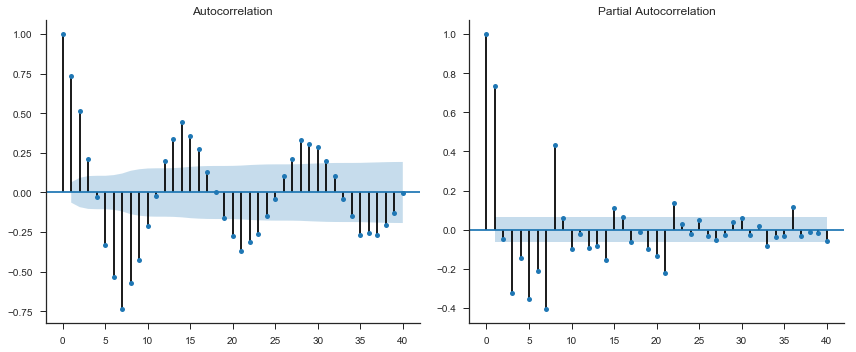

In [26]:
#ACF and PACF of residuals
acf_pacf_plot(resid_rw.dropna().as_matrix())

In [27]:
#Forecast intervals of seasonal random walk. Will not use in report due to negative values
from scipy.stats import norm
intv = pd.concat([pred-norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1)),
                   pred+norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1))], axis=1)
intv.tail().round(3)

,0,1
2015-09-07,-152.968,454.610
2015-09-08,-156.939,458.581
2015-09-09,-160.860,462.502
2015-09-10,-164.732,466.374
2015-09-11,-168.557,470.199


## Exponential Smoothing

### Simple Exponential Smoothing

In [28]:
#Fit SES model
import forecast

ses=forecast.ses(y)
ses.fit()
fitted_ses=pd.Series(ses.smooth(), index=y.index)
ses.summary()

 Simple exponential smoothing

 Smoothing parameter:
 alpha  0.421 (0.035) 

 In-sample fit:
 MSE               339.326
 Log-likelihood   -4081.139
 AIC               8168.279
 BIC               8182.823


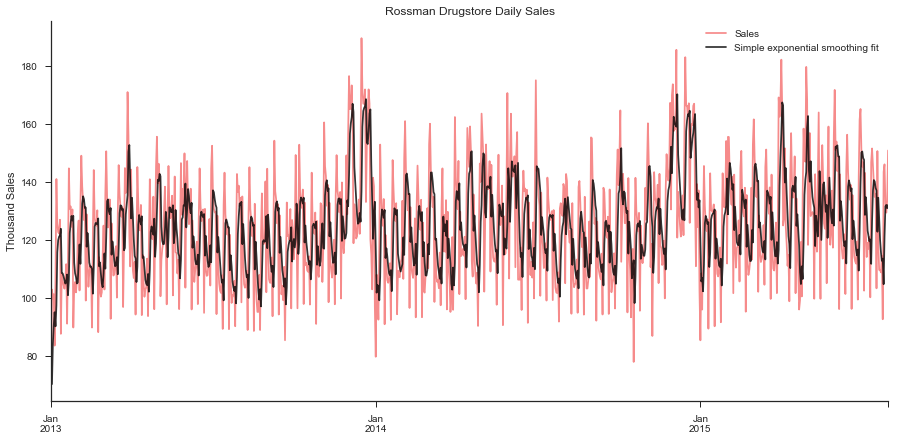

In [29]:
#Plot SES fit
fig, ax= plt.subplots(figsize=(15,7))
y.plot(color=red, label='Sales')
fitted_ses.plot(color='black', label='Simple exponential smoothing fit', alpha=0.8)
ax.set_xlabel('')
ax.set_ylabel('Thousand Sales')
ax.set_title('Rossman Drugstore Daily Sales')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

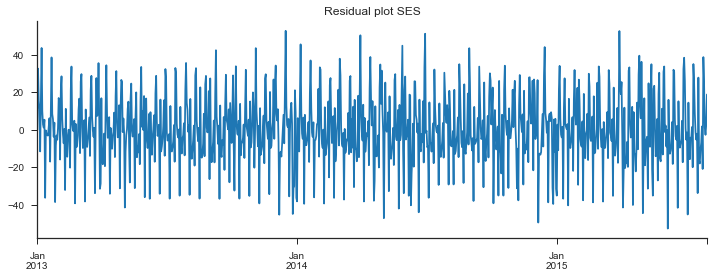

In [30]:
#Plot residuals of SES
resid_ses=y-fitted_ses
fig, ax= plt.subplots(figsize=(12,4))
resid_ses.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot SES')
sns.despine()
plt.show()

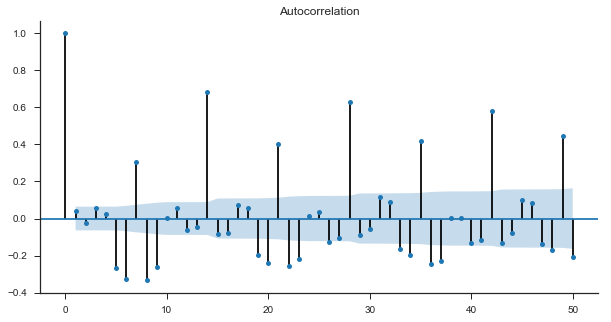

In [31]:
#ACF of residuals of SES
fig, ax = plt.subplots(figsize=(10,5))
sm.graphics.tsa.plot_acf(resid_ses, lags=50, ax=ax)
sns.despine()
plt.show()
fig.savefig('sesauto.png',bbox_inches='tight')

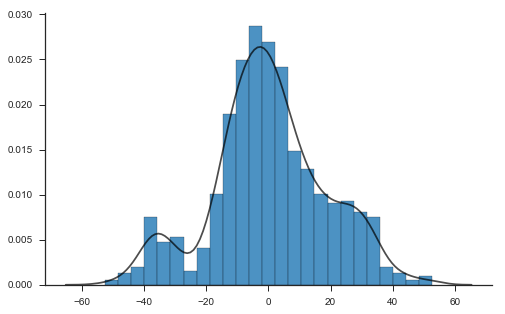

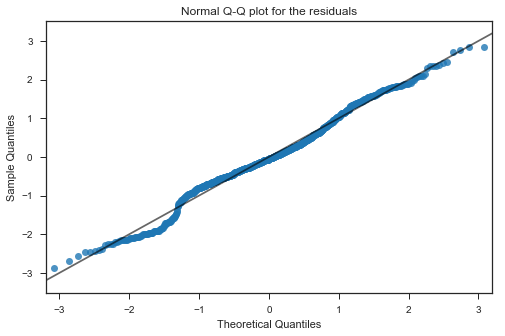

In [32]:
#Histogram and QQ plot of SES residuals
from forecast import histogram, qq_plot

histogram(resid_ses)
plt.show()

qq_plot(resid_ses)
plt.show()

In [33]:
print('Residual skewness of SES: {:.3f}'.format(resid_ses.skew()))
print('Residual kurtosis of SES: {:.3f}'.format(resid_ses.kurt()))

Residual skewness of SES: -0.042
Residual kurtosis of SES: 0.104


### Holt-Winters Exponential Smoothing

In [34]:
#Additive non-damped
ahw=forecast.holtwinters(y, additive=True, damped=False, m=7)
ahw.fit()
ahw.summary()

 Additive Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.783 (0.029)
 beta  (trend)    0.000 (0.037)
 delta (seasonal) 0.603 (0.104)
 
 In-sample fit:
 MSE               153.907
 RMSE              12.406
 Log-likelihood   -3708.761
 AIC               7425.523
 BIC               7444.915


In [35]:
#Additive damped
ahw_damped=forecast.holtwinters(y, additive=True, damped=True, m=7)
ahw_damped.fit()
ahw_damped.summary()

 Additive Holt-winters exponential smoothing (damped trend)

 Smoothing parameters:
 alpha (level)    0.619 (0.107)
 beta  (trend)    0.292 (0.220)
 delta (seasonal) 0.361 (0.104)
 phi (damping)    0.191 (0.101)
 
 In-sample fit:
 MSE               153.679
 RMSE              12.397
 Log-likelihood   -3708.061
 AIC               7426.122
 BIC               7450.362


In [36]:
#Multiplicative non-damped
mhw=forecast.holtwinters(y, additive=False, damped=False, m=7)
mhw.fit()
mhw.summary()

 Multiplicative Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.765 (0.030)
 beta  (trend)    0.000 (0.033)
 delta (seasonal) 0.640 (0.089)
 
 In-sample fit:
 MSE               155.321
 RMSE              12.463
 Log-likelihood   -3713.067
 AIC               7434.134
 BIC               7453.526


In [37]:
#Multiplicative damped
mhw_damped=forecast.holtwinters(y, additive=False, damped=True, m=7)
mhw_damped.fit()
mhw_damped.summary()

 Multiplicative Holt-winters exponential smoothing (damped trend)

 Smoothing parameters:
 alpha (level)    0.765 (0.029)
 beta  (trend)    0.000 (0.032)
 delta (seasonal) 0.640 (0.097)
 phi (damping)    0.763 (0.034)
 
 In-sample fit:
 MSE               155.488
 RMSE              12.469
 Log-likelihood   -3713.573
 AIC               7437.145
 BIC               7461.385


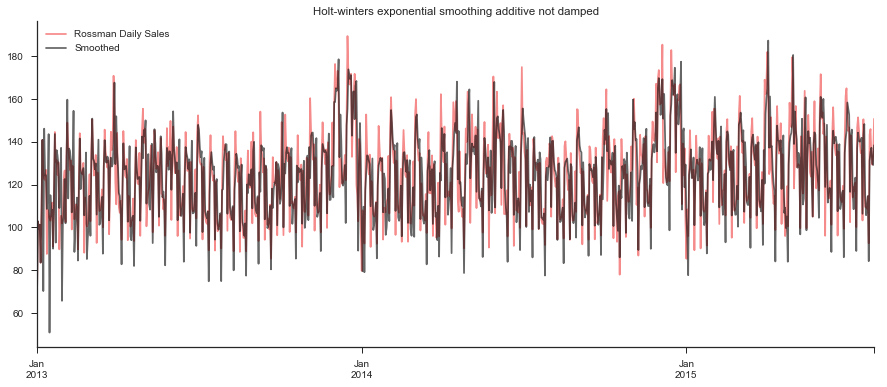

In [38]:
#Smoothed fit of selected model AHW non-damped
smoothed=pd.Series(ahw.smooth(), index=y.index)

fig, ax= plt.subplots(figsize=(15,6))

y.plot(color=red, label='Rossman Daily Sales')
smoothed.plot(color='black', label='Smoothed', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt-winters exponential smoothing additive not damped', fontsize=11.5)
sns.despine()
plt.show()
fig.savefig('holtwintersfull.png',bbox_inches='tight')

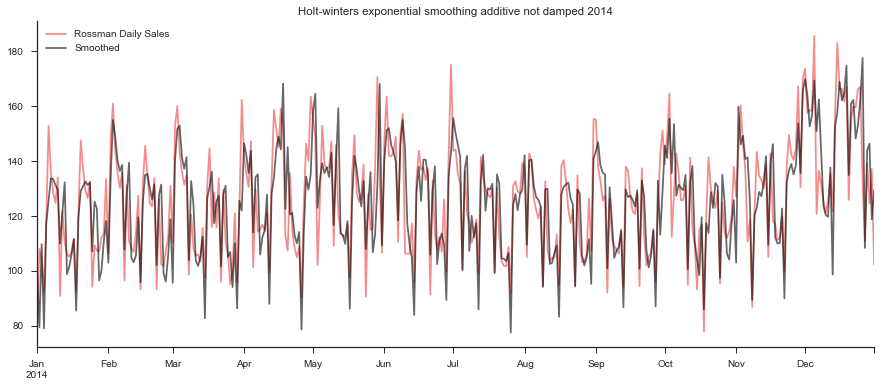

In [39]:
#Closer look of smoothed values but for 2014 only
smoothed=pd.Series(ahw.smooth(), index=y.index)

fig, ax= plt.subplots(figsize=(15,6))

y['2014-01-01':'2014-12-31'].plot(color=red, label='Rossman Daily Sales')
smoothed['2014-01-01':'2014-12-31'].plot(color='black', label='Smoothed', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt-winters exponential smoothing additive not damped 2014', fontsize=11.5)
sns.despine()
plt.show()
fig.savefig('holtwinters2014.png',bbox_inches='tight')

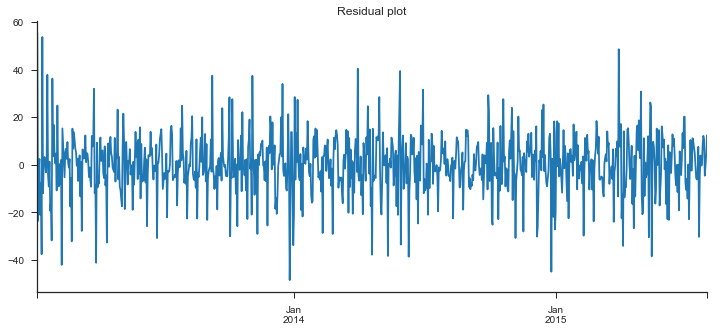

In [40]:
#Residuals of AHW. We remove the first 7 observations as they are for initialisitation only
resid_ahw = (y-ahw.smooth())[7:]

fig, ax= plt.subplots(figsize=(12,5))
resid_ahw.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

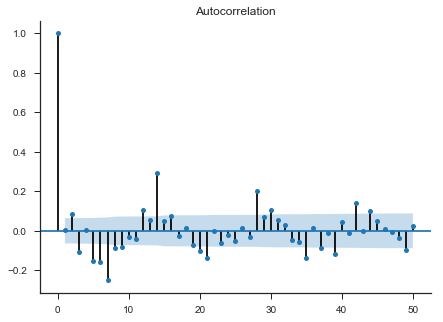

In [41]:
#ACF of residuals AHW
fig, ax = plt.subplots(figsize=(7,5))
sm.graphics.tsa.plot_acf(resid_ahw, lags=50, ax=ax)
sns.despine()
plt.show()
fig.savefig('residautohw.png',bbox_inches='tight')

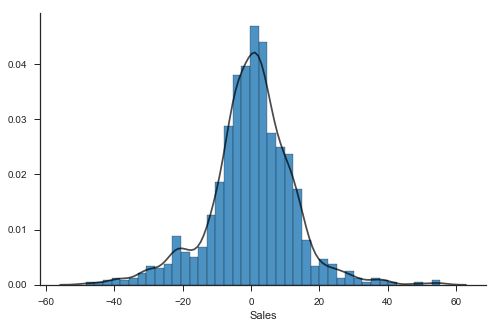

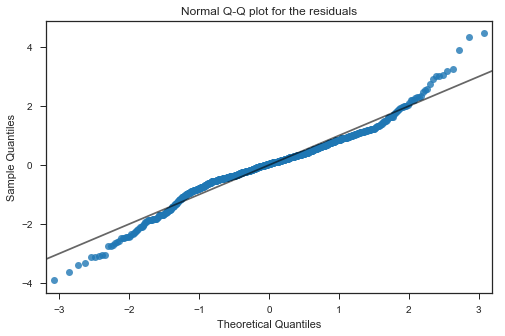

In [42]:
#Histogram and QQ plot of AHW residuals
from forecast import histogram, qq_plot

histogram(resid_ahw)
plt.show()

qq_plot(resid_ahw)
plt.show()

In [43]:
print('Residual skewness AHW non-damped: {:.3f}'.format(resid_ahw.skew()))
print('Residual kurtosis AHW non-damped: {:.3f}'.format(resid_ahw.kurt()))

Residual skewness AHW non-damped: -0.133
Residual kurtosis AHW non-damped: 2.143


In [44]:
#Real time forecasting of all Holt-Winters methods. Validation is from beginning of 2015

validation=y['2015-01-01':].index
start = y.index.get_loc('2015-01-01')

results_es=pd.DataFrame(0.0, index=y.iloc[start:].index, columns=['Seasonal Random Walk','Simple Exponential Smoothing',
                                                               'Additive Holt-Winters','Additive Damped Holt-Winters',
                                                               'Multiplicative Holt-Winters', 
                                                               'Multiplicative Damped Holt-Winters', 'Actual'])
results_es['Actual'] = y.iloc[start:]

for i in range(start, len(y)):
    
    j=i-start
        
    #seasonal random walk forecast
    results_es.iloc[j,0]=y.iloc[i-7]
    
    #simple exponential smoothing
    model = forecast.ses(y.iloc[:i])
    model.fit()
    results_es.iloc[j,1]=model.forecast(1)[0]
    
    #additive holt winters
    model = forecast.holtwinters(y.iloc[:i] , additive=True, damped=False, m=7)
    model.fit()
    results_es.iloc[j,2]=model.forecast(1)[0]
    
    #additive damped holt winters
    model = forecast.holtwinters(y.iloc[:i] , additive=True, damped=True, m=7)
    model.fit()
    results_es.iloc[j,3]=model.forecast(1)[0]
    
    #multiplicative holt winters
    model = forecast.holtwinters(y.iloc[:i] , additive=False, damped=False, m=7)
    model.fit()
    results_es.iloc[j,4]=model.forecast(1)[0]

    #multiplicative damped holt winters
    model = forecast.holtwinters(y.iloc[:i] , additive=False, damped=True, m=7)
    model.fit()
    results_es.iloc[j,5]=model.forecast(1)[0]

In [45]:
from statlearning import rmse_jack

table = pd.DataFrame(0.0, index=results_es.columns[:-1], columns=['RMSE','SE'])
for i in range(len(results_es.columns)-1):
    table.iloc[i,0], table.iloc[i,1] = rmse_jack(results_es.iloc[:,i], results_es.iloc[:,-1])
table.round(3)

,RMSE,SE
Seasonal Random Walk,26.683,1.272
Simple Exponential Smoothing,21.505,1.061
Additive Holt-Winters,15.362,0.783
Additive Damped Holt-Winters,15.478,0.799
Multiplicative Holt-Winters,15.041,0.798
Multiplicative Damped Holt-Winters,15.042,0.798


## ARIMA

### Seasonal ARIMA

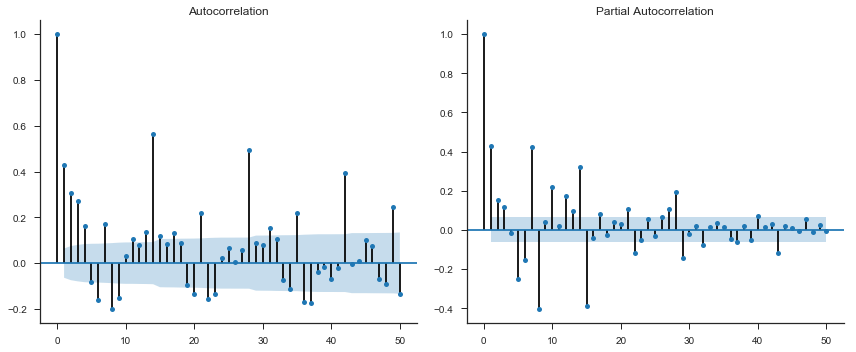

In [46]:
#ACF and PACF without any differencing
fig, ax = plt.subplots(1,2, figsize=(12,5))
sm.graphics.tsa.plot_acf(y, lags=50, ax=ax[0])
sm.graphics.tsa.plot_pacf(y, lags=50, ax=ax[1])
sns.despine()
fig.tight_layout()
plt.show()

In [47]:
#Calculating differences of the data for ARIMA modeling
diffs=pd.DataFrame(y.copy())
diffs.columns.values[0]='Original'
diffs['First_Diff']=y-y.shift(1)
diffs['Seasonal_Diff']=y-y.shift(7)
diffs['Diff']=diffs['First_Diff']-diffs['First_Diff'].shift(7)
diffs=diffs.dropna()
diffs.tail().round(3)

,Original,First_Diff,Seasonal_Diff,Diff
Date,,,,
2015-07-27,146.047,2.587,27.944,35.106
2015-07-28,132.727,-13.320,23.074,-4.870
2015-07-29,129.374,-3.353,19.710,-3.364
2015-07-30,133.551,4.177,24.754,5.044
2015-07-31,150.821,17.270,36.276,11.522


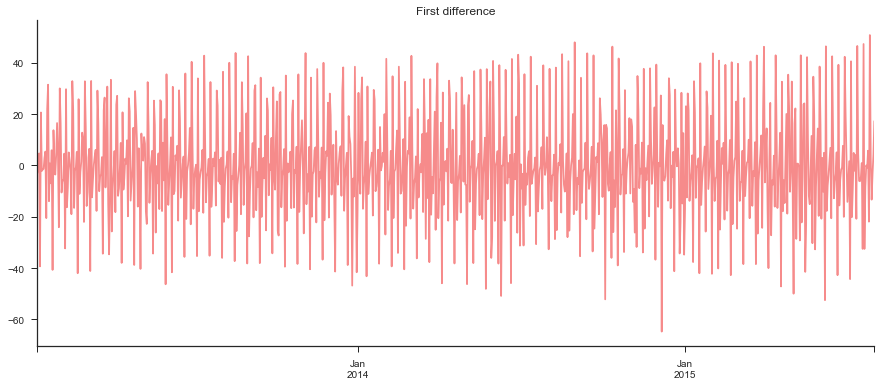

In [48]:
#First difference
ts_plot(diffs['First_Diff'])
plt.title('First difference')
plt.show()

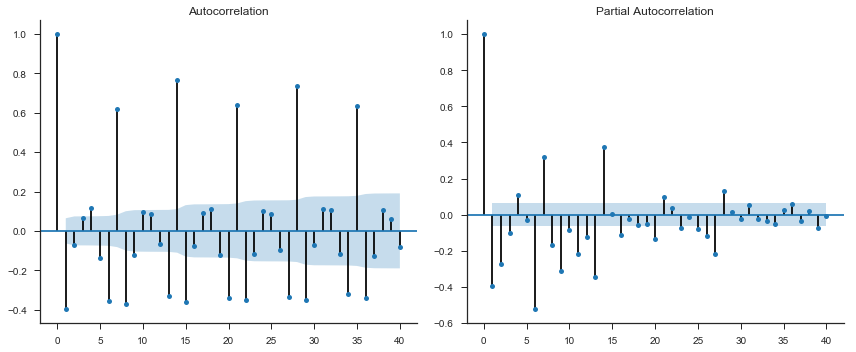

In [49]:
#ACF and PACF plots
acf_pacf_plot(diffs['First_Diff'])
plt.show()

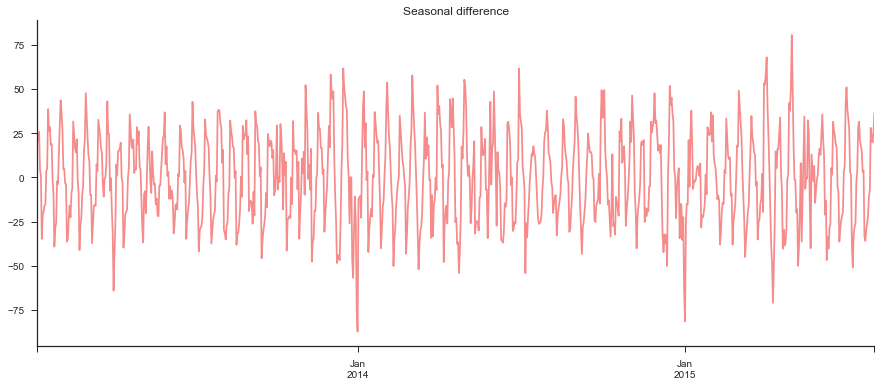

In [50]:
#Seasonal differences
ts_plot(diffs['Seasonal_Diff'])
plt.title('Seasonal difference')
plt.show()

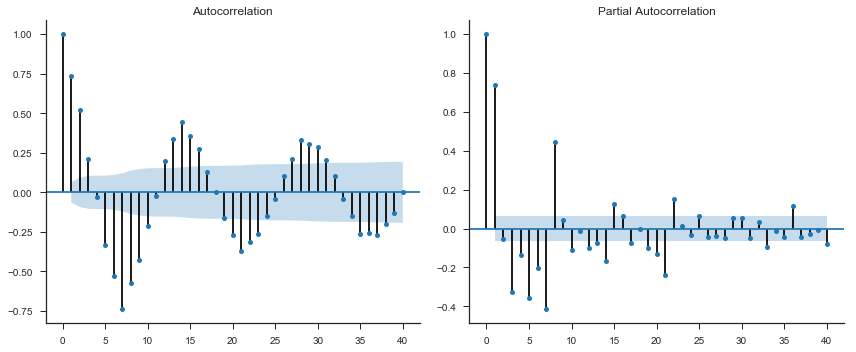

In [51]:
#ACF and PACF of seasonal differences
acf_pacf_plot(diffs['Seasonal_Diff'])
plt.show()

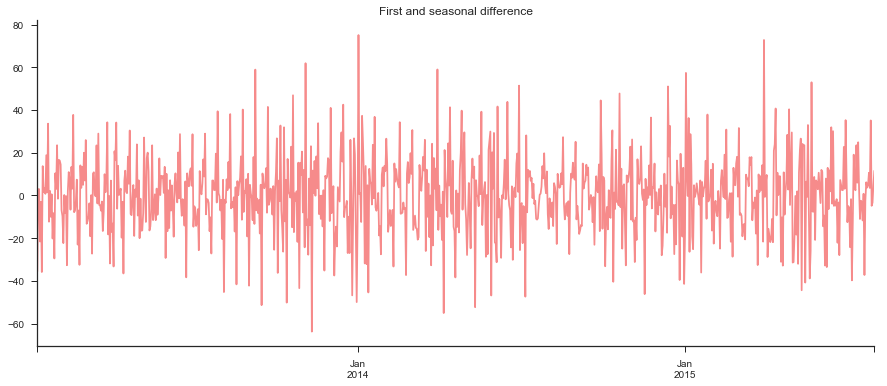

In [52]:
#First and seasonal difference together
ts_plot(diffs['Diff'])
plt.title('First and seasonal difference')
plt.show()

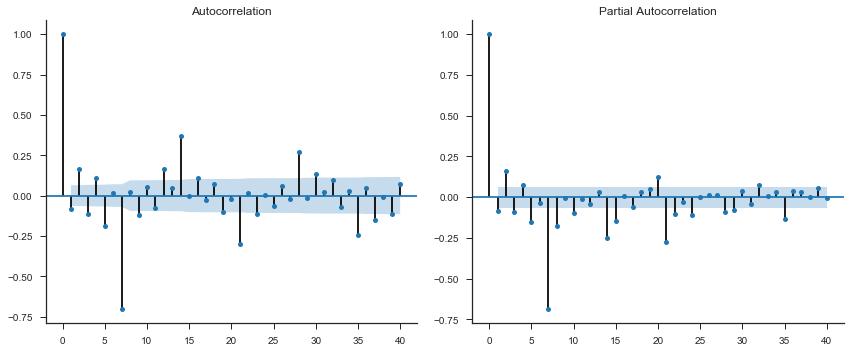

In [53]:
#ACF and PACF of first and seasonal differences
acf_pacf_plot(diffs['Diff'])
plt.show()

Both decrease exponentially at the lags which suggests both AR and MA model for the seasonal part so (1,1,1)

#### SARIMA (0,1,0)(1,1,1)

In [54]:
#Fit first ARIMA model
sarima_010111=sm.tsa.statespace.SARIMAX(y,  order=(0, 1, 0), seasonal_order=(1, 1, 1, 7)).fit()
print(sarima_010111.summary())

                                 Statespace Model Results                                
Dep. Variable:                             Sales   No. Observations:                  942
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 7)   Log Likelihood               -3595.050
Date:                           Sat, 04 Nov 2017   AIC                           7196.100
Time:                                   14:49:29   BIC                           7210.644
Sample:                               01-01-2013   HQIC                          7201.644
                                    - 07-31-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7       -0.2808      0.028     -9.986      0.000      -0.336      -0.226
ma.S.L7       -0.9427      0.011    -87.601

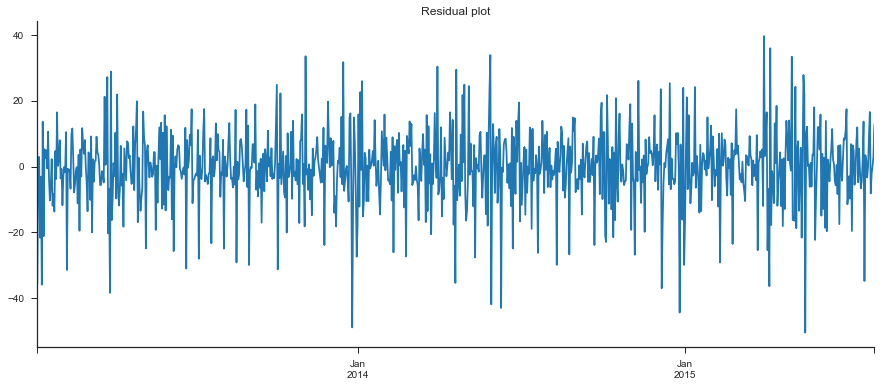

In [55]:
#Residuals of (010)(111)
resid_010111=sarima_010111.resid[8:]
ts_plot(resid_010111, color=blue)
plt.title('Residual plot')
plt.show()

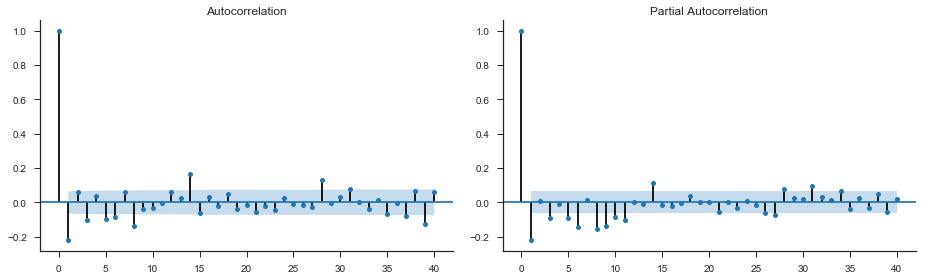

In [56]:
#ACF and PACF of (010)(111)
fig, ax = plt.subplots(1,2, figsize=(13,4))
sm.graphics.tsa.plot_acf(resid_010111, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(resid_010111, lags=40, ax=ax[1])
sns.despine()
fig.tight_layout()
fig.savefig('acfpacfresid.png',bbox_inches='tight')

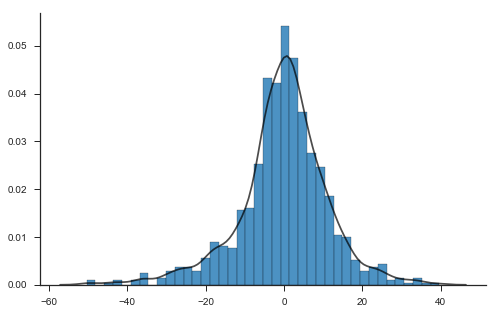

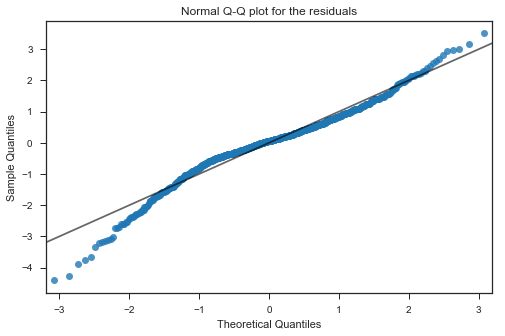

In [57]:
#Histogram and QQ plot of (010)(111)
histogram(resid_010111)
plt.show()

qq_plot(resid_010111)
plt.show()

#### SARIMA (1,1,1)(1,1,1)
Fit (111)(111) based on above residual ACF and PACF for (010)(111)

In [58]:
sarima_111111=sm.tsa.statespace.SARIMAX(y,  order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)).fit()
print(sarima_111111.summary())

                                 Statespace Model Results                                
Dep. Variable:                             Sales   No. Observations:                  942
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -3536.711
Date:                           Sat, 04 Nov 2017   AIC                           7083.422
Time:                                   14:49:35   BIC                           7107.662
Sample:                               01-01-2013   HQIC                          7092.661
                                    - 07-31-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7423      0.020     38.066      0.000       0.704       0.781
ma.L1         -0.9998      0.092    -10.849

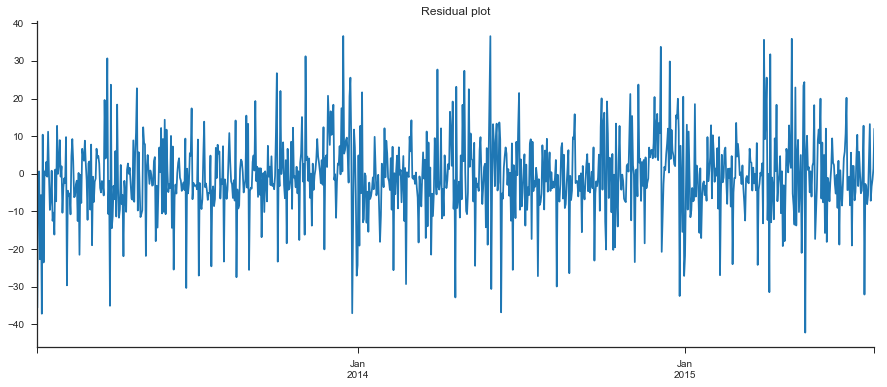

In [59]:
#Residual plot for (111)(111)
resid_111111=sarima_111111.resid[8:]
ts_plot(resid_111111, color=blue)
plt.title('Residual plot')
plt.show()

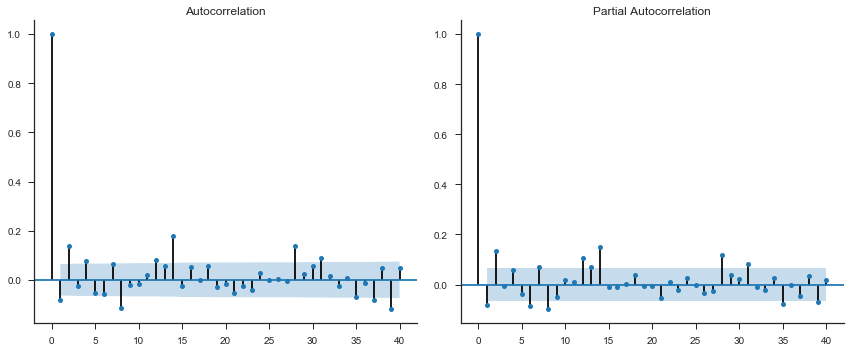

In [60]:
#ACF and PACF of residuals for (111)(111)
acf_pacf_plot(resid_111111)
plt.show()

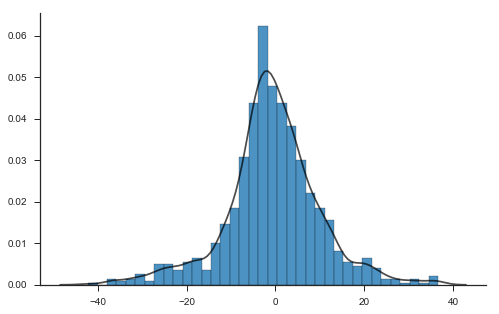

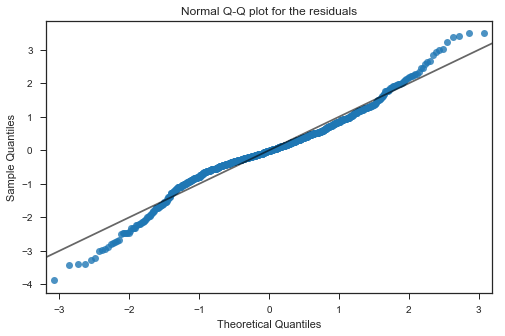

In [61]:
#Histogram and QQ plot of residuals for (111)(111)
histogram(resid_111111)
plt.show()

qq_plot(resid_111111)
plt.show()

#### SARIMA (X,1,X)(1,1,1)
Try other models varying AR(p) and MA(q)

In [62]:
sarima_110111=sm.tsa.statespace.SARIMAX(y,  order=(1, 1, 0), seasonal_order=(1, 1, 1, 7)).fit()
print(sarima_110111.summary())

                                 Statespace Model Results                                
Dep. Variable:                             Sales   No. Observations:                  942
Model:             SARIMAX(1, 1, 0)x(1, 1, 1, 7)   Log Likelihood               -3570.257
Date:                           Sat, 04 Nov 2017   AIC                           7148.514
Time:                                   14:49:38   BIC                           7167.906
Sample:                               01-01-2013   HQIC                          7155.906
                                    - 07-31-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2338      0.027     -8.673      0.000      -0.287      -0.181
ar.S.L7       -0.3256      0.030    -10.919

In [63]:
sarima_210111=sm.tsa.statespace.SARIMAX(y,  order=(2, 1, 0), seasonal_order=(1, 1, 1, 7)).fit()
print(sarima_210111.summary())

                                 Statespace Model Results                                
Dep. Variable:                             Sales   No. Observations:                  942
Model:             SARIMAX(2, 1, 0)x(1, 1, 1, 7)   Log Likelihood               -3570.098
Date:                           Sat, 04 Nov 2017   AIC                           7150.196
Time:                                   14:49:40   BIC                           7174.436
Sample:                               01-01-2013   HQIC                          7159.435
                                    - 07-31-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2394      0.027     -8.874      0.000      -0.292      -0.187
ar.L2         -0.0194      0.030     -0.650

In [64]:
sarima_310111=sm.tsa.statespace.SARIMAX(y,  order=(3, 1, 0), seasonal_order=(1, 1, 1, 7)).fit()
print(sarima_310111.summary())

                                 Statespace Model Results                                
Dep. Variable:                             Sales   No. Observations:                  942
Model:             SARIMAX(3, 1, 0)x(1, 1, 1, 7)   Log Likelihood               -3564.820
Date:                           Sat, 04 Nov 2017   AIC                           7141.640
Time:                                   14:49:42   BIC                           7170.728
Sample:                               01-01-2013   HQIC                          7152.728
                                    - 07-31-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2450      0.027     -8.928      0.000      -0.299      -0.191
ar.L2         -0.0489      0.031     -1.587

In [65]:
sarima_211111=sm.tsa.statespace.SARIMAX(y,  order=(2, 1, 1), seasonal_order=(1, 1, 1, 7)).fit()
print(sarima_211111.summary())

                                 Statespace Model Results                                
Dep. Variable:                             Sales   No. Observations:                  942
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -3569.922
Date:                           Sat, 04 Nov 2017   AIC                           7151.844
Time:                                   14:49:45   BIC                           7180.932
Sample:                               01-01-2013   HQIC                          7162.932
                                    - 07-31-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7785      0.812     -0.959      0.337      -2.369       0.812
ar.L2         -0.1046      0.196     -0.533

In [66]:
sarima_311111=sm.tsa.statespace.SARIMAX(y,  order=(3, 1, 1), seasonal_order=(1, 1, 1, 7)).fit()
print(sarima_311111.summary())

                                 Statespace Model Results                                
Dep. Variable:                             Sales   No. Observations:                  942
Model:             SARIMAX(3, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -3526.557
Date:                           Sat, 04 Nov 2017   AIC                           7067.114
Time:                                   14:49:50   BIC                           7101.050
Sample:                               01-01-2013   HQIC                          7080.049
                                    - 07-31-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6743      0.028     23.808      0.000       0.619       0.730
ar.L2          0.1748      0.039      4.465

#### SARIMA (3,1,1)(1,1,1)
Choose based on AIC

In [67]:
#Fit (311)(111)
sarima_311111=sm.tsa.statespace.SARIMAX(y,  order=(3, 1, 1), seasonal_order=(1, 1, 1, 7)).fit()
print(sarima_311111.summary())

                                 Statespace Model Results                                
Dep. Variable:                             Sales   No. Observations:                  942
Model:             SARIMAX(3, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -3526.557
Date:                           Sat, 04 Nov 2017   AIC                           7067.114
Time:                                   14:49:55   BIC                           7101.050
Sample:                               01-01-2013   HQIC                          7080.049
                                    - 07-31-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6743      0.028     23.808      0.000       0.619       0.730
ar.L2          0.1748      0.039      4.465

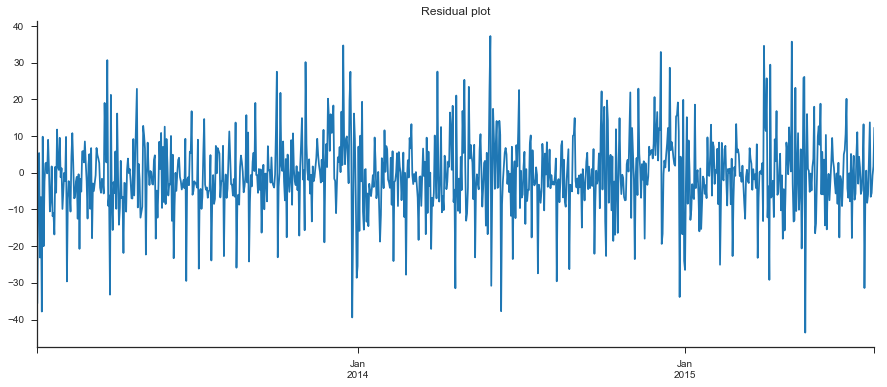

In [68]:
#Residuals of (311)(111)
resid_311111=sarima_311111.resid[8:]
ts_plot(resid_311111, color=blue)
plt.title('Residual plot')
plt.show()

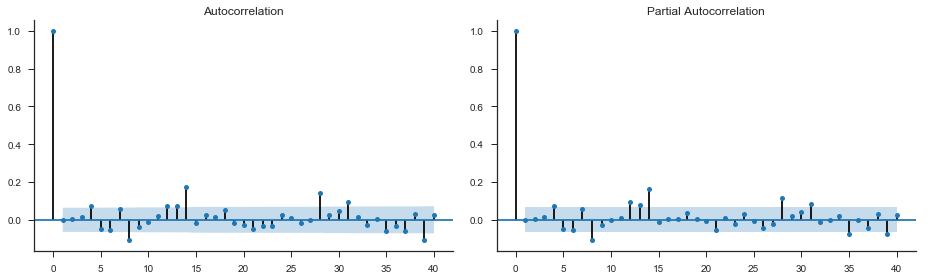

In [69]:
#ACF and PACF of chosen ARIMA model (311)(111)
fig, ax = plt.subplots(1,2, figsize=(13,4))
sm.graphics.tsa.plot_acf(resid_311111, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(resid_311111, lags=40, ax=ax[1])
sns.despine()
fig.tight_layout()
fig.savefig('acfpacfresidchosen.png',bbox_inches='tight')

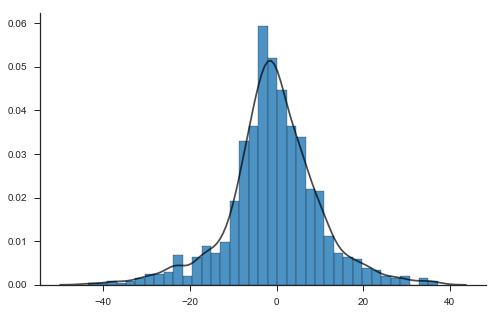

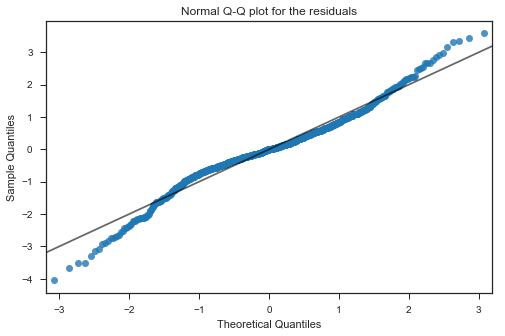

In [70]:
#Histogram and QQ plots of (311)(111)
histogram(resid_311111)
plt.show()

qq_plot(resid_311111)
plt.show()

In [71]:
print('Kurtosis of ARIMA(311)(111)', resid_311111.kurt())
print('Skew of ARIMA(311)(111)', resid_311111.skew())

Kurtosis of ARIMA(311)(111) 1.77392324359
Skew of ARIMA(311)(111) -0.145491964118


## Model Validation

In [72]:
#Real time forecasting to compare SRW, SES, HW, and ARIMA. Validation starts beginning of 2015
#This cell can take a while to run

validation=y['2015-01-01':].index
start = y.index.get_loc('2015-01-01')

results=pd.DataFrame(0.0, index=y.iloc[start:].index, columns=['Seasonal Random Walk','Simple Exponential Smoothing',
                                                               'Additive Holt-Winters', 
                                                               'Seasonal ARIMA', 'Actual'])
results['Actual'] = y.iloc[start:]

for i in range(start, len(y)):
    
    j=i-start
        
    #Seasonal random walk forecast
    results.iloc[j,0]=y.iloc[i-7]
    
    #Simple exponential smoothing
    model = forecast.ses(y.iloc[:i])
    model.fit()
    results.iloc[j,1]=model.forecast(1)[0]
    
    #Additive holt winters
    model = forecast.holtwinters(y.iloc[:i] , additive=True, damped=False, m=7)
    model.fit()
    results.iloc[j,2]=model.forecast(1)[0]
    
    #Seasonal ARIMA
    model = sm.tsa.statespace.SARIMAX(y.iloc[:i],  order=(3, 1, 1), seasonal_order=(1, 1, 1, 7)).fit()
    results.iloc[j,3]=model.forecast()[0]

In [73]:
from statlearning import rmse_jack

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(len(results.columns)-1):
    table.iloc[i,0], table.iloc[i,1] = rmse_jack(results.iloc[:,i], results.iloc[:,-1])
table.round(3)

,RMSE,SE
Seasonal Random Walk,26.683,1.272
Simple Exponential Smoothing,21.505,1.061
Additive Holt-Winters,15.362,0.783
Seasonal ARIMA,11.042,0.774


In [74]:
# Real time forecasting for same as above, but validation starts beginning of November 2014 to include holiday season
#This cell can take a while to run

validation=y['2014-11-01':].index
start = y.index.get_loc('2014-11-01')

results_2=pd.DataFrame(0.0, index=y.iloc[start:].index, columns=['Seasonal Random Walk','Simple Exponential Smoothing',
                                                               'Additive Holt-Winters', 
                                                               'Seasonal ARIMA', 'Actual'])
results_2['Actual'] = y.iloc[start:]

for i in range(start, len(y)):
    
    j=i-start
        
    #Seasonal random walk forecast
    results_2.iloc[j,0]=y.iloc[i-7]
    
    #Simple exponential smoothing
    model = forecast.ses(y.iloc[:i])
    model.fit()
    results_2.iloc[j,1]=model.forecast(1)[0]
    
    #Additive holt winters
    model = forecast.holtwinters(y.iloc[:i] , additive=True, damped=False, m=7)
    model.fit()
    results_2.iloc[j,2]=model.forecast(1)[0]
    
    #Seasonal ARIMA
    model = sm.tsa.statespace.SARIMAX(y.iloc[:i],  order=(3, 1, 1), seasonal_order=(1, 1, 1, 7)).fit()
    results_2.iloc[j,3]=model.forecast()[0]

In [75]:
from statlearning import rmse_jack

table = pd.DataFrame(0.0, index=results_2.columns[:-1], columns=['RMSE','SE'])
for i in range(len(results_2.columns)-1):
    table.iloc[i,0], table.iloc[i,1] = rmse_jack(results_2.iloc[:,i], results_2.iloc[:,-1])
table.round(3)

,RMSE,SE
Seasonal Random Walk,26.968,1.063
Simple Exponential Smoothing,21.556,0.927
Additive Holt-Winters,15.696,0.722
Seasonal ARIMA,11.653,0.700


In [76]:
#Chosen model based on validation
sarima=sm.tsa.statespace.SARIMAX(y,  order=(3, 1, 1), seasonal_order=(1, 1, 1, 7)).fit()

## Forecast

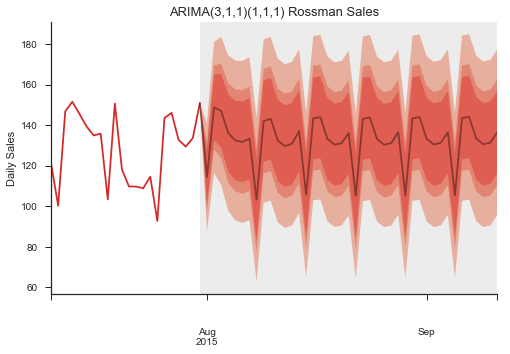

In [77]:
#Forecasts for six weeks using ARIMA (311)(111) model
h=42 

test=pd.period_range(start=y.index[-1]+1, periods=h, freq='D')

y_pred = sarima.forecast(steps=h)
y_pred = pd.Series(y_pred, index=test)

intv1 = sarima.get_forecast(h).conf_int(alpha=0.2)
intv2 = sarima.get_forecast(h).conf_int(alpha=0.1)
intv3 = sarima.get_forecast(h).conf_int(alpha=0.01)

intv1=pd.DataFrame(intv1, index=test)
intv2=pd.DataFrame(intv2, index=test)
intv3=pd.DataFrame(intv3, index=test)


fig, ax = forecast.fanchart(y[920:], y_pred, intv1, intv2, intv3)
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_ylabel('Daily Sales')
ax.set_title('ARIMA(3,1,1)(1,1,1) Rossman Sales', fontsize=13)
sns.despine()
plt.show()
fig.savefig('forecastdaily.png',bbox_inches='tight')

## Monthly Analysis

In [78]:
#Combine data to get sum for each month. Scale down so data is in millions.
ym = y.copy()
ym.index = ym.index.to_datetime()
ym.index = ym.index.to_period(freq='M')
ym = pd.DataFrame(ym).reset_index().groupby('Date')['Sales'].sum()
ym = ym/1000
ym.head()

Date
2013-01    3.425724
2013-02    3.299770
2013-03    3.908490
2013-04    3.576190
2013-05    3.894977
Freq: M, Name: Sales, dtype: float64

### EDA

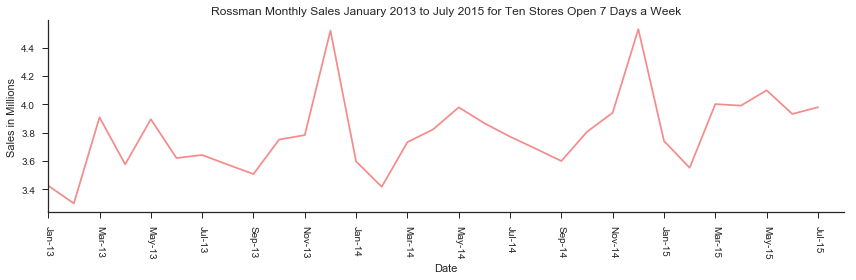

In [79]:
#Time series plot over data
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(ym.values, color=red)

ax.set_xlim(0, len(ym))

indexes = np.arange(0, len(ym), 2) # we will place ticks every 30 days, starting with the first observation 
ax.set_xticks(indexes)
ax.set_xticklabels([ym.index[i].strftime('%b-%y') for i in indexes], rotation='-90')

ax.set_xlabel('Date')
ax.set_ylabel('Sales in Millions')
ax.set_title('Rossman Monthly Sales January 2013 to July 2015 for Ten Stores Open 7 Days a Week')

plt.tight_layout()

sns.despine()
plt.show()
fig.savefig('monthlysales.png',bbox_inches='tight')

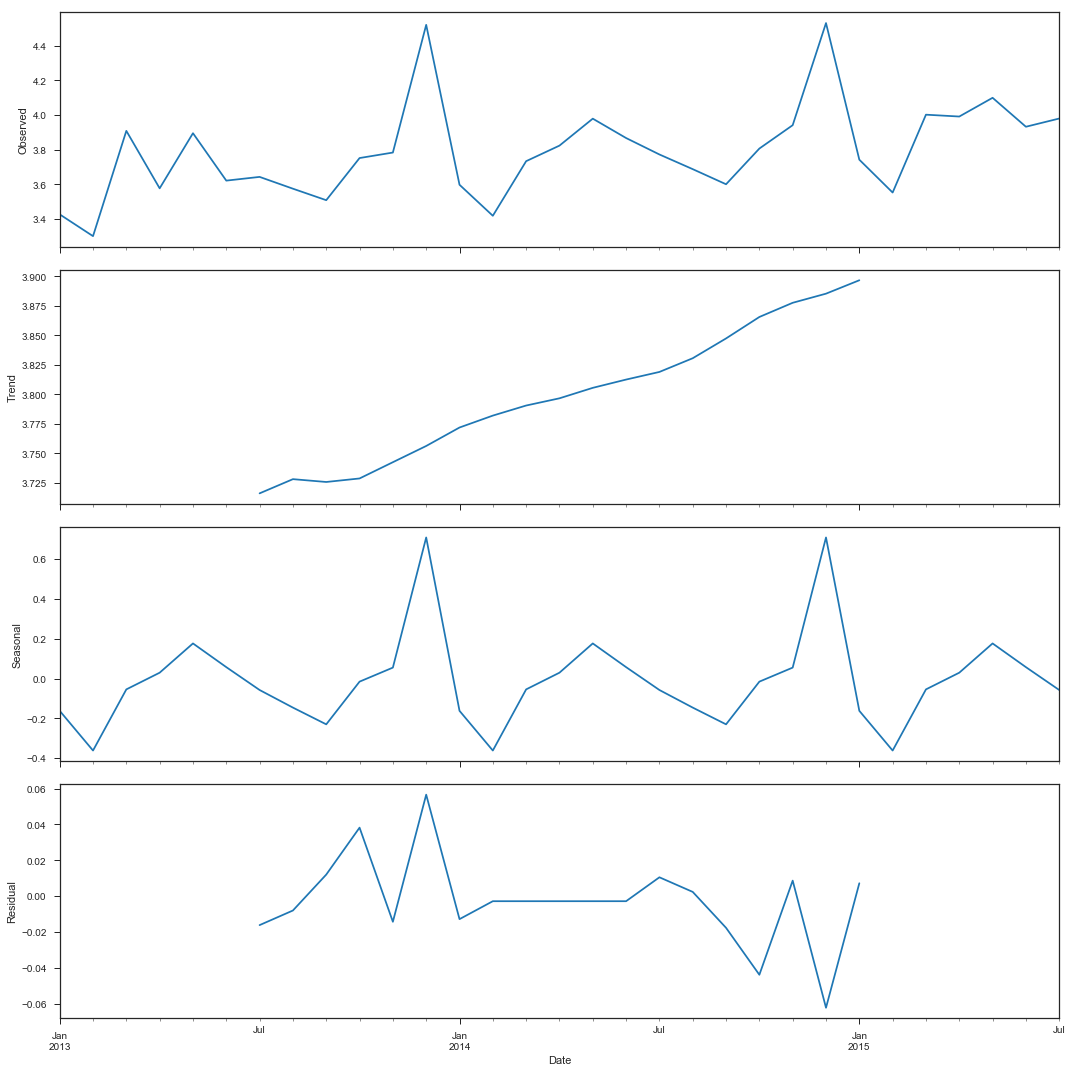

In [80]:
#Decomposition
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

ym.index = ym.index.to_timestamp()

decomposition = sm.tsa.seasonal_decompose(ym, model='additive')
fig = decomposition.plot()
plt.show()
fig.savefig('monthdecomp.png',bbox_inches='tight')

### Modelling

#### Seasonal Random Walk

In [81]:
#Set forecast horizon as 4 and repeat last observed value 4 times
h = 4
test=pd.period_range(start=ym.index[-1]+1, periods=h,freq='M')
pred=pd.Series(np.repeat(ym.iloc[-1], h), index=test)
pred.head()

2015-08    3.979796
2015-09    3.979796
2015-10    3.979796
2015-11    3.979796
Freq: M, dtype: float64

#### Holt-Winters

In [82]:
#Monthly data additive holt winters
amhw=forecast.holtwinters(ym, additive=True, damped=False, m=12)
amhw.fit()
amhw.summary()

 Additive Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.050 (0.100)
 beta  (trend)    0.564 (0.948)
 delta (seasonal) 0.718 (0.269)
 
 In-sample fit:
 MSE               0.014
 RMSE              0.117
 Log-likelihood    22.476
 AIC               -36.952
 BIC               -31.216


In [83]:
#Monthly data additive holt winters damped
amhw_d=forecast.holtwinters(ym, additive=True, damped=True, m=12)
amhw_d.fit()
amhw_d.summary()

 Additive Holt-winters exponential smoothing (damped trend)

 Smoothing parameters:
 alpha (level)    0.050 (0.220)
 beta  (trend)    0.566 (2.434)
 delta (seasonal) 0.719 (0.507)
 phi (damping)    1.000 (0.180)
 
 In-sample fit:
 MSE               0.015
 RMSE              0.121
 Log-likelihood    21.476
 AIC               -32.951
 BIC               -25.781


In [84]:
#Monthly holt winters multiplicative
mmhw=forecast.holtwinters(ym, additive=False, damped=False, m=12)
mmhw.fit()
mmhw.summary()

 Multiplicative Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.054 (0.032)
 beta  (trend)    0.406 (0.182)
 delta (seasonal) 0.767 (0.228)
 
 In-sample fit:
 MSE               0.014
 RMSE              0.120
 Log-likelihood    21.634
 AIC               -35.268
 BIC               -29.532


In [85]:
#Monthly holt winters multiplicative damped
mmhw_d=forecast.holtwinters(ym, additive=False, damped=True, m=12)
mmhw_d.fit()
mmhw_d.summary()

 Multiplicative Holt-winters exponential smoothing (damped trend)

 Smoothing parameters:
 alpha (level)    0.049 (0.150)
 beta  (trend)    0.456 (1.438)
 delta (seasonal) 0.756 (0.683)
 phi (damping)    1.000 (0.180)
 
 In-sample fit:
 MSE               0.015
 RMSE              0.124
 Log-likelihood    20.638
 AIC               -31.275
 BIC               -24.105


In [86]:
# Real time forecasting for various Holt-Winters methods. Validation is from beginning of 2015

validation=ym['2015-01-01':].index
start = ym.index.get_loc('2015-01-01')

results_esm=pd.DataFrame(0.0, index=ym.iloc[start:].index, columns=['Seasonal Random Walk','Simple Exponential Smoothing',
                                                               'Additive Holt-Winters','Additive Damped Holt-Winters',
                                                               'Multiplicative Holt-Winters', 
                                                               'Multiplicative Damped Holt-Winters', 'Actual'])
results_esm['Actual'] = ym.iloc[start:]

for i in range(start, len(ym)):
    
    j=i-start
        
    #Seasonal random walk forecast
    results_esm.iloc[j,0]=ym.iloc[i-12]
    
    #Simple exponential smoothing
    model = forecast.ses(ym.iloc[:i])
    model.fit()
    results_esm.iloc[j,1]=model.forecast(1)[0]
    
    #Additive holt winters
    model = forecast.holtwinters(ym.iloc[:i] , additive=True, damped=False, m=12)
    model.fit()
    results_esm.iloc[j,2]=model.forecast(1)[0]
    
    #Additive damped holt winters
    model = forecast.holtwinters(ym.iloc[:i] , additive=True, damped=True, m=12)
    model.fit()
    results_esm.iloc[j,3]=model.forecast(1)[0]
    
    #Multiplicative holt winters
    model = forecast.holtwinters(ym.iloc[:i] , additive=False, damped=False, m=12)
    model.fit()
    results_esm.iloc[j,4]=model.forecast(1)[0]

    #Multiplicative damped holt winters
    model = forecast.holtwinters(ym.iloc[:i] , additive=False, damped=True, m=12)
    model.fit()
    results_esm.iloc[j,5]=model.forecast(1)[0]

In [87]:
from statlearning import rmse_jack

table = pd.DataFrame(0.0, index=results_esm.columns[:-1], columns=['RMSE','SE'])
for i in range(len(results_esm.columns)-1):
    table.iloc[i,0], table.iloc[i,1] = rmse_jack(results_esm.iloc[:,i], results_esm.iloc[:,-1])
table.round(3)

,RMSE,SE
Seasonal Random Walk,0.170,0.026
Simple Exponential Smoothing,0.192,0.063
Additive Holt-Winters,0.138,0.028
Additive Damped Holt-Winters,0.139,0.027
Multiplicative Holt-Winters,0.151,0.029
Multiplicative Damped Holt-Winters,0.151,0.028


#### ARIMA

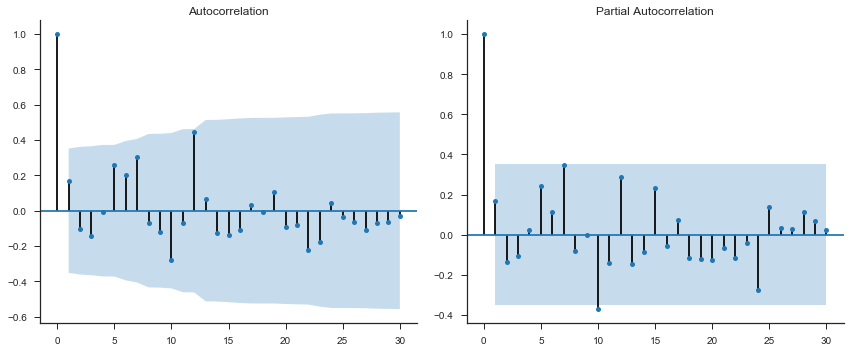

In [88]:
#ACF and PACF without any differencing
fig, ax = plt.subplots(1,2, figsize=(12,5))
sm.graphics.tsa.plot_acf(ym, lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(ym, lags=30, ax=ax[1])
sns.despine()
fig.tight_layout()
plt.show()

In [89]:
#Monthly data differenced
diffs_m=pd.DataFrame(ym.copy())
diffs_m.columns.values[0]='Original'
diffs_m['First_Diff']=ym-ym.shift(1)
diffs_m['Seasonal_Diff']=ym-ym.shift(12)
diffs_m['Diff']=diffs_m['First_Diff']-diffs_m['First_Diff'].shift(7)
diffs_m=diffs_m.dropna()
diffs_m.tail().round(3)

,Original,First_Diff,Seasonal_Diff,Diff
Date,,,,
2015-03-01,4.002,0.450,0.269,0.535
2015-04-01,3.991,-0.011,0.168,0.077
2015-05-01,4.100,0.108,0.121,-0.098
2015-06-01,3.932,-0.167,0.065,-0.302
2015-07-01,3.980,0.048,0.208,-0.543


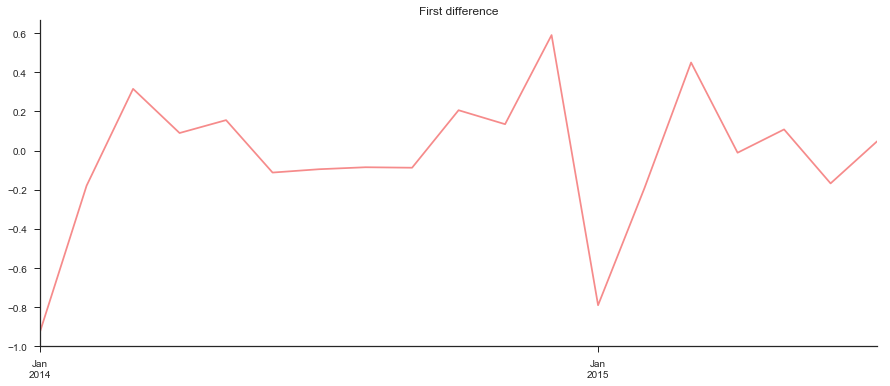

In [90]:
#First differences
ts_plot(diffs_m['First_Diff'])
plt.title('First difference')
plt.show()

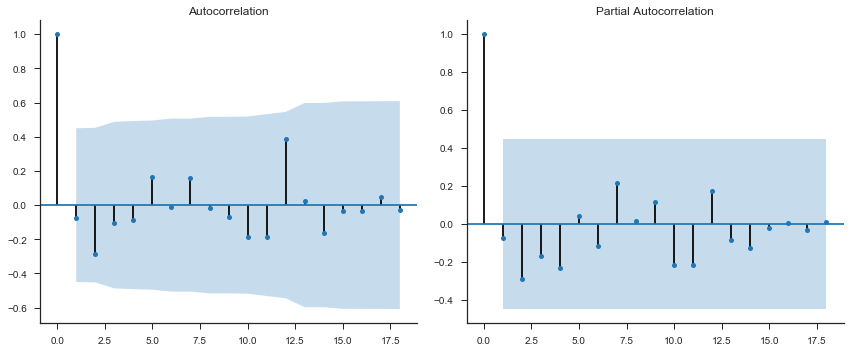

In [91]:
#ACF and PACF first differences
fig, ax = plt.subplots(1,2, figsize=(12,5))
sm.graphics.tsa.plot_acf(diffs_m['First_Diff'], lags=18, ax=ax[0])
sm.graphics.tsa.plot_pacf(diffs_m['First_Diff'], lags=18, ax=ax[1])
sns.despine()
fig.tight_layout()

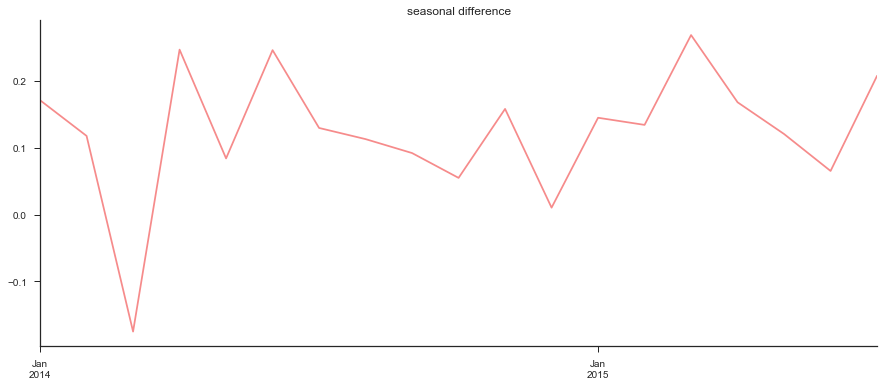

In [92]:
#Seasonal differences
ts_plot(diffs_m['Seasonal_Diff'])
plt.title('seasonal difference')
plt.show()

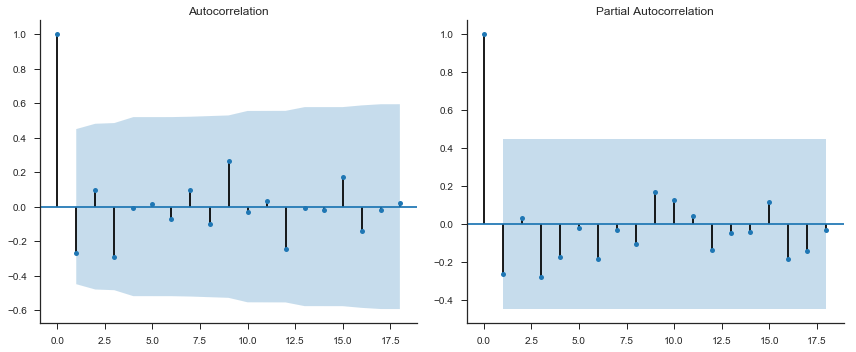

In [93]:
#ACF and PACF of seasonal differences
fig, ax = plt.subplots(1,2, figsize=(12,5))
sm.graphics.tsa.plot_acf(diffs_m['Seasonal_Diff'], lags=18, ax=ax[0])
sm.graphics.tsa.plot_pacf(diffs_m['Seasonal_Diff'], lags=18, ax=ax[1])
sns.despine()
fig.tight_layout()

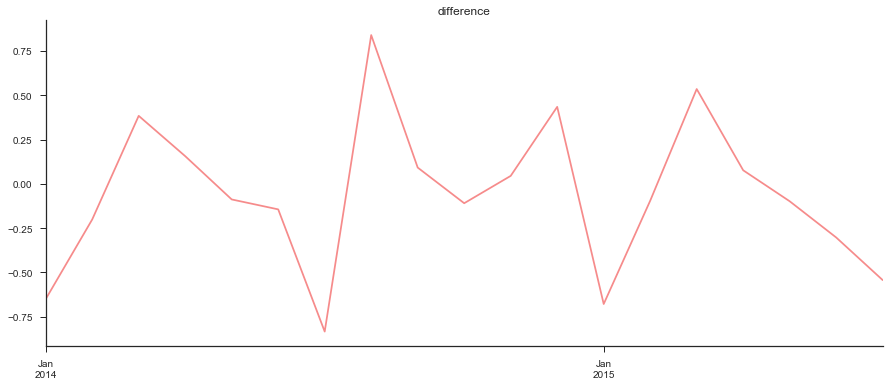

In [94]:
#Both first and seasonal differences
ts_plot(diffs_m['Diff'])
plt.title('difference')
plt.show()

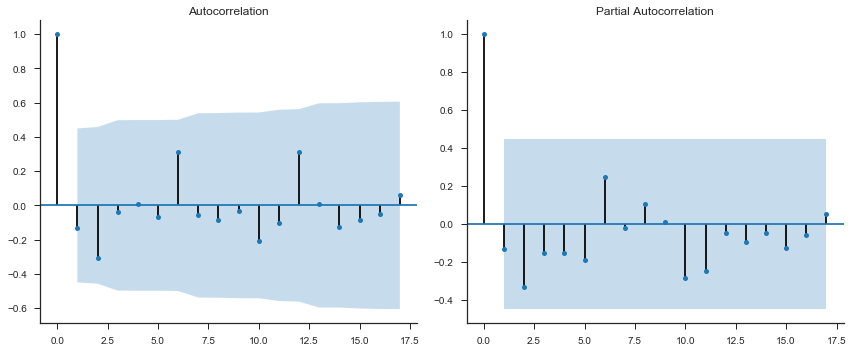

In [95]:
#ACF and PACF of both seasonal and first differences
fig, ax = plt.subplots(1,2, figsize=(12,5))
sm.graphics.tsa.plot_acf(diffs_m['Diff'], lags=17, ax=ax[0])
sm.graphics.tsa.plot_pacf(diffs_m['Diff'], lags=17, ax=ax[1])
sns.despine()
fig.tight_layout()

No clear patterns are visible so we try a few ARIMA specifications for our limited data

In [96]:
sarima_m100010=sm.tsa.statespace.SARIMAX(ym,  order=(1, 0, 0), seasonal_order=(0, 1, 0, 12)).fit()
print(sarima_m100010.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                   31
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                  10.686
Date:                            Sat, 04 Nov 2017   AIC                            -17.371
Time:                                    15:28:51   BIC                            -14.503
Sample:                                01-01-2013   HQIC                           -16.437
                                     - 07-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5059      0.311      1.625      0.104      -0.104       1.116
sigma2         0.0187      0.007   

In [97]:
sarima_m110110=sm.tsa.statespace.SARIMAX(ym,  order=(1, 1, 0), seasonal_order=(1, 1, 0, 12)).fit()
print(sarima_m110110.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                   31
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  13.547
Date:                            Sat, 04 Nov 2017   AIC                            -21.093
Time:                                    15:28:51   BIC                            -16.791
Sample:                                01-01-2013   HQIC                           -19.691
                                     - 07-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6323      0.157     -4.033      0.000      -0.940      -0.325
ar.S.L12      -0.4757      0.391   

In [98]:
sarima_m111110=sm.tsa.statespace.SARIMAX(ym,  order=(1, 1, 1), seasonal_order=(1, 1, 0, 12)).fit()
print(sarima_m111110.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                   31
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                  16.362
Date:                            Sat, 04 Nov 2017   AIC                            -24.723
Time:                                    15:28:52   BIC                            -18.987
Sample:                                01-01-2013   HQIC                           -22.854
                                     - 07-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2905      0.319     -0.910      0.363      -0.916       0.335
ma.L1         -0.9932     12.184   

In [99]:
#Real time forecasting for SRW, SES, HW, and ARIMA. Validation starting in March 2015 so ARIMA could be fit
#Differencing data and small number of points limits size of validation data

validation=y['2015-03-01':].index
start = ym.index.get_loc('2015-03-01')

results_m=pd.DataFrame(0.0, index=ym.iloc[start:].index, columns=['Seasonal Random Walk','Simple Exponential Smoothing',
                                                               'Additive Holt-Winters', 
                                                               'Seasonal ARIMA', 'Actual'])
results_m['Actual'] = ym.iloc[start:]

for i in range(start, len(ym)):
    
    j=i-start
        
    #Seasonal random walk forecast
    results_m.iloc[j,0]=ym.iloc[i-12]
    
    #Simple exponential smoothing
    model = forecast.ses(ym.iloc[:i])
    model.fit()
    results_m.iloc[j,1]=model.forecast(1)[0]
    
    #Additive holt winters
    model = forecast.holtwinters(ym.iloc[:i] , additive=True, damped=False, m=12)
    model.fit()
    results_m.iloc[j,2]=model.forecast(1)[0]
    
    #Seasonal ARIMA
    model = sm.tsa.statespace.SARIMAX(ym.iloc[:i],  order=(1, 1, 1), seasonal_order=(1, 1, 0, 12)).fit()
    results_m.iloc[j,3]=model.forecast()[0]

In [100]:
from statlearning import rmse_jack

table = pd.DataFrame(0.0, index=results_m.columns[:-1], columns=['RMSE','SE'])
for i in range(len(results_m.columns)-1):
    table.iloc[i,0], table.iloc[i,1] = rmse_jack(results_m.iloc[:,i], results_m.iloc[:,-1])
table.round(3)

,RMSE,SE
Seasonal Random Walk,0.180,0.034
Simple Exponential Smoothing,0.140,0.039
Additive Holt-Winters,0.124,0.045
Seasonal ARIMA,0.222,0.134


In [101]:
#Forecasts for chosen Holt-Winters model
h=4

model = amhw

test=pd.period_range(start=ym.index[-1]+1, periods=h, freq='M')

pred=pd.Series(model.forecast(h), index=test)

intv1=pd.DataFrame(model.intervalforecast(h, level=.8), index=test)
intv2=pd.DataFrame(model.intervalforecast(h, level=.9), index=test)
intv3=pd.DataFrame(model.intervalforecast(h, level=.99), index=test)

In [102]:
#Values of point forecasts and interval forecasts in millions
print(pred)
print(intv1) #80% intervals
print(intv2) #90% intervals
print(intv3) #99% intervals

2015-08    3.815938
2015-09    3.761854
2015-10    4.017902
2015-11    4.062059
Freq: M, dtype: float64
                0         1
2015-08  3.665754  3.966122
2015-09  3.546456  3.977252
2015-10  3.750397  4.285406
2015-11  3.748885  4.375234
                0         1
2015-08  3.623179  4.008697
2015-09  3.485394  4.038314
2015-10  3.674563  4.361240
2015-11  3.660104  4.464014
                0         1
2015-08  3.514078  4.117797
2015-09  3.328920  4.194789
2015-10  3.480236  4.555567
2015-11  3.432601  4.691518
